In [3]:
# Load some required modules
# If you get an import error, make sure the libraries are installed:

import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm

from smile.log import log2dl

In [4]:
# find and set the path to your log file (replace subj and sess with your info)
log_file = 'C:/Users/lucas/Desktop/CompPsyLabs/flanker_lucas`_20231006_135530/data/Flanker/lucas`/20231006_135530/log_flanker_0.slog'

# load it in
dl = log2dl(log_file)

# convert it to a Pandas DataFrame
df = pd.DataFrame(dl)

# show the first few lines
df.head()

,resp_map_left,resp_map_right,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,correct,location_0,location_1,log_time,condition,direction,stimulus,log_num
0,F,J,0,0,614291.245843,0.0,J,614292.641885,0.000423,1.396042,True,710.459222,722.621813,614293.175700,incongruent,right,<<<><<<,0
1,F,J,0,1,614293.180030,0.0,J,614294.107470,0.000399,0.927440,True,1263.628121,738.365273,614294.909083,congruent,right,>>>>>>>,0
2,F,J,0,2,614294.929456,0.0,J,614297.041104,0.000574,2.111649,True,709.919319,680.897822,614297.613093,mix,right,><<><<>,0
3,F,J,0,3,614297.628565,0.0,F,614298.535804,0.000426,0.907239,True,1138.734104,689.450893,614299.489321,mix,left,<>><>><,0
4,F,J,0,4,614299.494902,0.0,F,614300.719387,0.000543,1.224485,True,651.400316,657.683606,614301.285142,incongruent,left,>>><>>>,0


In [5]:
# load in the sysinfo slog
sinfo = log2dl('C:/Users/lucas/Desktop/CompPsyLabs/flanker_lucas`_20231006_135530/data/Flanker/lucas`/20231006_135530/sysinfo.slog')[0]
sinfo

{'fullscreen': None,
 'locked': 0,
 'density': '1.0',
 'font_size': 45.0,
 'font_name': 'Roboto',
 'frame_rate': 60.0,
 'default_data_dir': '.\\data',
 'data_time': '20231006_135530',
 'debug': False,
 'resolution': None,
 'background_color': None,
 'scale_box_0': 1024,
 'scale_box_1': 768,
 'scale_up': True,
 'scale_down': True,
 'expname': 'Flanker',
 'processor': 'Intel64 Family 6 Model 140 Stepping 2, GenuineIntel',
 'python_version': '3.11.4',
 'system': 'Windows',
 'version': '',
 'author': '',
 'email': '',
 'date_last_update': '',
 'screen_size_0': 1920,
 'screen_size_1': 1200,
 'scale_factor': 1.0416666666666667,
 'log_num': 0}

In [6]:
# perform some quick data cleanup
# calculate change in x from previous location
df['dx'] = np.concatenate([[np.nan], 
                np.array(df['location_0'][1:]) - 
                np.array(df['location_0'][:-1])])

# calculate the offset from the center
df['x_offset'] = df['location_0'] - sinfo['screen_size_0']/2

# save the log(rt)
df['log_rt'] = np.log(df['rt'])

# create a correct response column b/c we didn't save it
df['correct_resp'] = df['resp']
df.loc[~df['correct'] & (df['resp']=='F'), 'correct_resp'] = 'J'
df.loc[~df['correct'] & (df['resp']=='J'), 'correct_resp'] = 'F'

# print out all the column names
print(df.columns)
df.head()

Index(['resp_map_left', 'resp_map_right', 'block_num', 'trial_num',
       'stim_on_time', 'stim_on_error', 'resp', 'resp_time_time',
       'resp_time_error', 'rt', 'correct', 'location_0', 'location_1',
       'log_time', 'condition', 'direction', 'stimulus', 'log_num', 'dx',
       'x_offset', 'log_rt', 'correct_resp'],
      dtype='object')


,resp_map_left,resp_map_right,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,...,location_1,log_time,condition,direction,stimulus,log_num,dx,x_offset,log_rt,correct_resp
0,F,J,0,0,614291.245843,0.0,J,614292.641885,0.000423,1.396042,...,722.621813,614293.175700,incongruent,right,<<<><<<,0,NaN,-249.540778,0.333641,J
1,F,J,0,1,614293.180030,0.0,J,614294.107470,0.000399,0.927440,...,738.365273,614294.909083,congruent,right,>>>>>>>,0,553.168900,303.628121,-0.075327,J
2,F,J,0,2,614294.929456,0.0,J,614297.041104,0.000574,2.111649,...,680.897822,614297.613093,mix,right,><<><<>,0,-553.708803,-250.080681,0.747469,J
3,F,J,0,3,614297.628565,0.0,F,614298.535804,0.000426,0.907239,...,689.450893,614299.489321,mix,left,<>><>><,0,428.814785,178.734104,-0.097350,F
4,F,J,0,4,614299.494902,0.0,F,614300.719387,0.000543,1.224485,...,657.683606,614301.285142,incongruent,left,>>><>>>,0,-487.333788,-308.599684,0.202521,F


WilcoxonResult(statistic=532.0, pvalue=0.0006806615685495657)

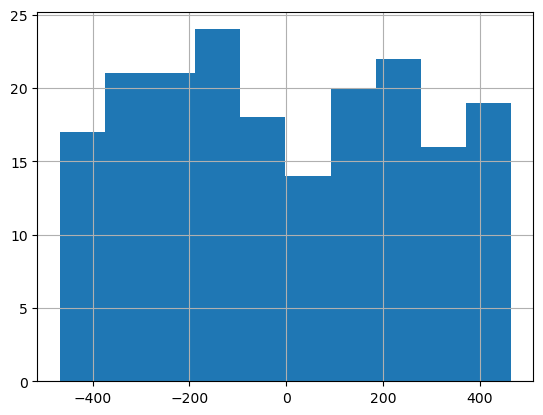

In [7]:
# plot the distribution of x_offset values (to see if it's skewed)
df['x_offset'].hist()

# BONUS: Use a non-parametric test to see whether they are skewed with respect to 0
# HINT: It's the sign rank test we talked about in class that was invented by Wilcoxon
stats.wilcoxon(df[df['condition']=='mix']['rt'],
                   df[df['condition']=='incongruent']['rt'])
#There is a significant difference between the paired groups, given the low p-value.

In [36]:
# perform the regression
import statsmodels.formula.api as smf
import statsmodels.api as sm

# build a linear regression
# YOUR CODE HERE TO DEFINE AND FIT THE MODEL
# you want to test if the log_rt is dependent on x_offset and direction (and their interaction)
model_offset = smf.ols("log_rt ~ x_offset", df).fit()
model_direction= smf.ols("log_rt ~ direction", df).fit()
model_interaction = smf.ols("log_rt ~ x_offset*direction", df).fit()

Log_rt vs. X_Offset Model Summary

In [37]:
model_offset.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_rt   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4960
Date:                Thu, 26 Oct 2023   Prob (F-statistic):              0.482
Time:                        14:12:16   Log-Likelihood:                -77.466
No. Observations:                 192   AIC:                             158.9
Df Residuals:                     190   BIC:                             165.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2516      0.026     -9.572      0.000      -0.303      -0.200
x_offset    6.853e-05   9.73e-05      0.704      0.482      -0.000       0.000
==============================================================================
Omnibus:                        5.291   Durbin-Watson:                   1.340
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                3.729
Skew:                           0.196   Prob(JB):                        0.155
Kurtosis:                       2.442   Cond. No.                         270.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Log_rt vs. Direction Model Summary

In [38]:
model_direction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_rt   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5846
Date:                Thu, 26 Oct 2023   Prob (F-statistic):              0.445
Time:                        14:12:17   Log-Likelihood:                -77.421
No. Observations:                 192   AIC:                             158.8
Df Residuals:                     190   BIC:                             165.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.2320      0.037     -6.245      0.000      -0.305      -0.159
direction[T.right]    -0.0402      0.053     -0.765      0.445      -0.144       0.063
==============================================================================
Omnibus:                        5.287   Durbin-Watson:                   1.324
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                3.497
Skew:                           0.162   Prob(JB):                        0.174
Kurtosis:                       2.424   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Log_rt vs. x_offset and direction interaction Model Summary

In [39]:
model_interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_rt   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.7320
Date:                Thu, 26 Oct 2023   Prob (F-statistic):              0.534
Time:                        14:12:17   Log-Likelihood:                -76.601
No. Observations:                 192   AIC:                             161.2
Df Residuals:                     188   BIC:                             174.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.2320      0.037     -6.239      0.000      -0.305      -0.159
direction[T.right]             -0.0406      0.053     -0.772      0.441      -0.144       0.063
x_offset                        0.0002      0.000      1.244      0.215      -0.000       0.000
x_offset:direction[T.right]    -0.0002      0.000     -1.070      0.286      -0.001       0.000
==============================================================================
Omnibus:                        4.819   Durbin-Watson:                   1.363
Prob(Omnibus):                  0.090   Jarque-Bera (JB):                3.469
Skew:                           0.187   Prob(JB):                        0.176
Kurtosis:                       2.458   Cond. No.                         713.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Anova (x_offset model)

In [40]:
# perform an ANOVA on the model to show whether the main effects and interaction are significant
anova_lm(model_offset)

,df,sum_sq,mean_sq,F,PR(>F)
x_offset,1.0,0.065764,0.065764,0.495981,0.482134
Residual,190.0,25.192630,0.132593,NaN,NaN


Anova (direction model)

In [41]:
# perform an ANOVA on the model to show whether the main effects and interaction are significant
anova_lm(model_direction)

,df,sum_sq,mean_sq,F,PR(>F)
direction,1.0,0.077474,0.077474,0.584575,0.445473
Residual,190.0,25.180919,0.132531,NaN,NaN


Anova (interaction model)

In [44]:
# perform an ANOVA on the model to show whether the main effects and interaction are significant
anova_lm(model_interaction)

,df,sum_sq,mean_sq,F,PR(>F)
direction,1.0,0.077474,0.077474,0.583383,0.445947
x_offset,1.0,0.062069,0.062069,0.467378,0.495037
x_offset:direction,1.0,0.152073,0.152073,1.145111,0.285947
Residual,188.0,24.966777,0.132802,NaN,NaN


Simon Effect Evaluation

Given a PR(>F) = 0.450085 in the interaction model between direction and x_offset, my performance on the flanker task does NOT show the Simon Effect.